In [5]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
 
import pandas as pd
import numpy as np
import matplotlib as mpl
import seaborn as sns
import matplotlib.pylab as plt
import tqdm
import math
import os
import random

from collections import defaultdict
from itertools import product

from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

from dmba import plotDecisionTree, textDecisionTree

from matplotlib.patches import Ellipse
 
from matplotlib import rc, font_manager
font_path = '/Library/Fonts/NanumGothicBold.ttf'
fontprop = font_manager.FontProperties(fname=font_path, size=14)
 
from IPython.display import Image

sns.set(rc = {"figure.figsize": (20, 10)})

In [2]:
# 분포 볼 때 사용할 함수
def plot_dist(x, bins, hist = True, kde = None, rug = None, label = None, color=None, line_median = None, line_mean = None, x_format = False, y_format = False):
  data = np.asarray(x)
  sns.set(rc = {"figure.figsize": (20, 10)})
  ax = sns.distplot(data, bins = int(round((abs(data.max()) - abs(data.min())) * bins,1)), hist = hist, kde = kde, rug=rug, label = label, color=color)
  
  if line_median is None and line_mean is None:
    pass
  elif line_median is not None and line_mean is None:
    plt.axvline(round(np.median(data), 2), 1, 0, color = 'red', ls = '--', alpha = 0.5)
    plt.text(x = np.median(data), y = line_median, s = "Median:" + str(round(np.median(data), 3)), bbox = dict(facecolor = 'red', alpha = 0.3), fontsize = 14)
  elif line_median is None and line_mean is not None:
    plt.axvline(round(np.mean(data), 2), 1, 0, color = 'blue', ls = '--', alpha = 0.5)
    plt.text(x = np.mean(data), y = line_mean, s = "Mean:" + str(round(np.mean(data), 3)), bbox = dict(facecolor = 'blue', alpha = 0.3), fontsize = 14)
  else:
    plt.axvline(round(np.median(data), 2), 1, 0, color = 'red', ls = '--', alpha = 0.5)
    plt.axvline(round(np.mean(data), 2), 1, 0, color = 'blue', ls = '--', alpha = 0.5)
    plt.text(x = np.median(data), y = line_median, s = "Median:" + str(round(np.median(data), 3)), bbox = dict(facecolor = 'red', alpha = 0.3), fontsize = 14)
    plt.text(x = np.mean(data), y = line_mean, s = "Mean:" + str(round(np.mean(data), 3)), bbox = dict(facecolor = 'blue', alpha = 0.3), fontsize = 14)
  if y_format is True:
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
  if x_format is True:
    ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    
def plot_title(title, xlabel, ylabel, fontproperties = None, fontsize = None):
  plt.title(label = title, fontproperties = fontproperties, fontsize = fontsize)
  plt.xlabel(xlabel = xlabel, fontproperties = fontproperties, fontsize = fontsize)
  plt.ylabel(ylabel = ylabel, fontproperties = fontproperties, fontsize = fontsize)

In [3]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

In [4]:
loan200 = pd.read_csv('./data/loan200.csv')
loan3000 = pd.read_csv('./data/loan3000.csv', index_col=0)
loan_data = pd.read_csv('./data/loan_data.csv.gz', compression='gzip')

고전적인 통계 방법과 머신러닝의 가장 큰 차이점은 무엇일까?

# K 최근접 이웃

- K-Nearest Neighbors
  - 예측변수들이 <span style="color:orange">유사한</span> K개의 레코드를 찾는다.
  - 이 유사한 레코드들 중 <span style="color:orange">다수</span>가 속한 클래스가 무엇인지 찾은 후 새로운 레코드를 그 클래스에 할당한다. (분류)
  - 유사한 레코드들의 <span style="color:orange">평균</span>을 찾아서 새로운 레코드에 대한 예측값으로 사용한다 (예측)

## 대출 연체 예측
- A Small Example: Predicting Loan Default

In [5]:
print('payment_inc_ratio: 소득에 대한 대출 상환 비율')
print('dti: 소득에 대한 부채(모기지는 제외) 비율')
loan200.head()

payment_inc_ratio: 소득에 대한 대출 상환 비율
dti: 소득에 대한 부채(모기지는 제외) 비율


,outcome,payment_inc_ratio,dti
0,target,9.00000,22.50
1,default,5.46933,21.33
2,paid off,6.90294,8.97
3,paid off,11.14800,1.83
4,default,3.72120,10.81


In [6]:
predictors = ['payment_inc_ratio', 'dti']
outcome = 'outcome'


newloan = loan200.loc[0:0, predictors]
X = loan200.loc[1:, predictors]
y = loan200.loc[1:, outcome]

knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X, y)
knn.predict(newloan)
print(knn.predict_proba(newloan))

[[0.45 0.55]]


In [7]:
nbrs = knn.kneighbors(newloan)
nbrs

(array([[0.43787986, 0.88189485, 0.91751052, 1.65569826, 1.70611292,
         1.90596261, 2.08135622, 2.41682933, 2.44351029, 2.73230786,
         2.74245402, 2.86057968, 2.88767355, 2.99889915, 3.19912226,
         3.21420799, 3.36546794, 3.37976028, 3.462634  , 3.5414263 ]]),
 array([[ 34, 181, 180,  84,   8, 168,  20, 198,  76,  54, 140,  30,  65,
         162, 160, 111,  77,  45,  40, 138]]))

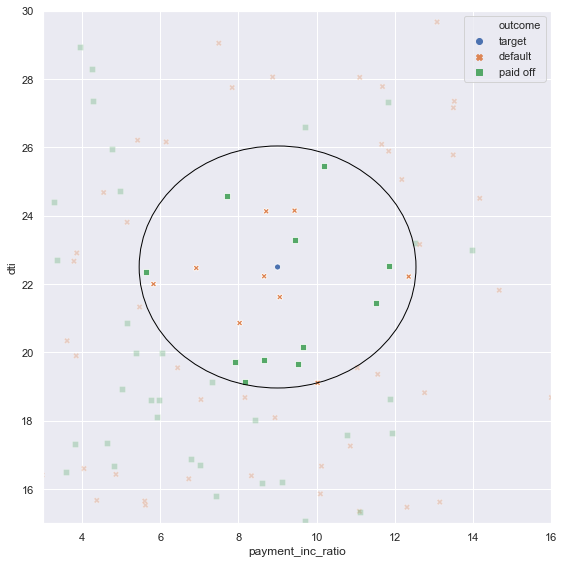

In [8]:
maxDistance = np.max(nbrs[0][0])

fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(x='payment_inc_ratio', y='dti', style='outcome', 
                hue='outcome', data=loan200, alpha=0.3, ax=ax)
sns.scatterplot(x='payment_inc_ratio', y='dti', style='outcome', 
                hue='outcome', 
                data=pd.concat([loan200.loc[0:0, :], loan200.loc[nbrs[1][0] + 1,:]]), 
                ax=ax, legend=False)
ellipse = Ellipse(xy=newloan.values[0], 
                  width=2 * maxDistance, height=2 * maxDistance,
                  edgecolor='black', fc='None', lw=1)
ax.add_patch(ellipse)
ax.set_xlim(3, 16)
ax.set_ylim(15, 30)

plt.tight_layout()
plt.show()

## 거리 지표

- 유클리드 거리(Eudlidean distance) = $ {\displaystyle \sqrt {(p_1-q_1)^2 + (p_2-q_2)^2 + ... + (p_n-q_n)^2} } $
  - x축 y축이 모두 좌표평면상 <span style="color:orange">거리의 개념으로 된 공간에서는 유클리디언 거리가 잘 동작</span>하지만, 일반적인 다변량 데이터에서 두 데이터간 제대로된 거리를 파악하기 위해서는 각 변수 별 상관관계를 고려해야 함
- 맨하탄 거리(Manhattan distance) = $ {\displaystyle \sum_{i=1}^n |a_i-b_i| }$
- 자카드 유사도(Jaccard similarity) = $ {\displaystyle \frac{|A ∩ B|}{|A ∪ B|} }$
- 마할라노비스 거리(Mahalanobis distance) = $ {\displaystyle (x-m)^T * C^{-1} * (x-m) }$
   - 서로 다른 의미를 지닌 <span style="color:orange">변수 간의 상관관계에 따라 거리를 조정</span>하기 위하여 공분산 행렬($C$) 사용
   - <span style="color:orange">평균과의 거리가 표준편차의 몇 배</span>인지를 나타내는 값
---
- 각 거리의 특징과 장단점을 알아보자  
[참고1](https://wiserloner.tistory.com/1089)  
[참고2](http://blog.naver.com/tlaja/220722933381)

## 원-핫 인코더

- 선형회귀나 로지스틱 회귀에서 원-핫 인코딩은 <span style="color:orange">다중공선성</span>과 관련된 문제를 일으킴 ⇢ 한 가변수를 생략해야 함
- 단, KNN이나 다른 방법에서는 이것이 문제가 되진 않음

In [9]:
pd.get_dummies(loan3000['purpose_'], dummy_na=True)

,credit_card,debt_consolidation,home_improvement,major_purchase,medical,other,small_business,NaN
32109,0,1,0,0,0,0,0,0
16982,1,0,0,0,0,0,0,0
25335,0,1,0,0,0,0,0,0
34580,0,0,0,1,0,0,0,0
14424,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
36589,0,1,0,0,0,0,0,0
43889,0,0,0,0,0,1,0,0
7219,0,1,0,0,0,0,0,0
8987,0,1,0,0,0,0,0,0


## 표준화(정규화, z-score)
- Standardization (Normalization, Z-Scores)

- $ {\displaystyle z  = \frac{x-\bar{x}}{s} }$
- KNN이나 다른 알고리즘(PCA, Clustering..)에서는 데이터를 미리 <span style="color:orange"> 표준화</span>하는 것이 필수임 (왜?)
---
- 표준화 종류
  - Z-score = <span style="color:orange"> $ {\displaystyle \frac{x-\bar{x}}{s} }$ </span>
  - Mean Normalisation = <span style="color:orange"> $ {\displaystyle \frac{x-\bar{x}}{max(x) - min(x)} }$ </span>
  - MinMaxScaler = <span style="color:orange"> $ {\displaystyle \frac{x-min(x)}{max(x) - min(x)} }$ </span>
  - MaxAbs = <span style="color:orange"> $ {\displaystyle \frac{x}{max(x)} }$ </span>
  - Robust = <span style="color:orange"> $ {\displaystyle \frac{x - median(x)}{75th\ quant(x) - 25th\ quant(x)} }$ </span>

In [5]:
loan_data = loan_data.drop(columns=['Unnamed: 0', 'status'])
loan_data['outcome'] = pd.Categorical(loan_data['outcome'], 
                                      categories=['paid off', 'default'], 
                                      ordered=True) # ordered=True는 왜 할까?

In [12]:
loan_data['outcome'].to_frame().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45342 entries, 0 to 45341
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   outcome  45342 non-null  category
dtypes: category(1)
memory usage: 44.5 KB


In [13]:
predictors = ['payment_inc_ratio', 'dti', 'revol_bal', 'revol_util']
outcome = 'outcome'

newloan = loan_data.loc[0:0, predictors]
newloan

,payment_inc_ratio,dti,revol_bal,revol_util
0,2.3932,1.0,1687,9.4


In [14]:
X = loan_data.loc[1:, predictors]
y = loan_data.loc[1:, outcome]

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X, y)

nbrs = knn.kneighbors(newloan)
print(X.iloc[nbrs[1][0], :])

       payment_inc_ratio   dti  revol_bal  revol_util
35536            1.47212  1.46       1686        10.0
33651            3.38178  6.37       1688         8.4
25863            2.36303  1.39       1691         3.5
42953            1.28160  7.14       1684         3.9
43599            4.12244  8.98       1684         7.2


In [17]:
newloan = loan_data.loc[0:0, predictors]
X = loan_data.loc[1:, predictors]
y = loan_data.loc[1:, outcome]

scaler = preprocessing.StandardScaler()
scaler.fit(X * 1.0)

X_std = scaler.transform(X * 1.0)
newloan_std = scaler.transform(newloan * 1.0)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_std, y)

nbrs = knn.kneighbors(newloan_std)
print(X.iloc[nbrs[1][0], :])

       payment_inc_ratio   dti  revol_bal  revol_util
2080             2.61091  1.03       1218         9.7
1438             2.34343  0.51        278         9.9
30215            2.71200  1.34       1075         8.5
28542            2.39760  0.74       2917         7.4
44737            2.34309  1.37        488         7.2


## K 선택하기

- K는 1보다 큰 편이 좋음 (왜? <span style="color:orange"> K가 너무 작거나 크면 어떤 문제가 발생하는가?</span>)
- 최적의 K를 결정하는 일반적인 규칙은 없다 (데이터에 따라 크게 달라짐)
- 데이터에 노이즈가 없고 잘 정제된 경우 K 값이 작을수록 잘 동작함 (SNR; Signal-to-Noise Ratio가 높은 데이터)
- 동률이 나오는 경우를 방지하기 위해 보통은 <span style="color:orange">홀수</span>를 사용함

In [18]:
predictors = ['payment_inc_ratio', 'dti', 'revol_bal', 'revol_util']
outcome = 'outcome'

X = loan_data.loc[1:, predictors]
y = loan_data.loc[1:, outcome]

In [19]:
from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)

In [21]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
#Train Model and Predict
k = 4
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
Pred_y = neigh.predict(X_test)
print("Accuracy of model at K=4 is", metrics.accuracy_score(y_test, Pred_y))

Accuracy of model at K=4 is 0.545374352188775


---
[https://towardsdatascience.com/how-to-find-the-optimal-value-of-k-in-knn-35d936e554eb]

Minimum error:- 0.41470944977395524 at K = 56


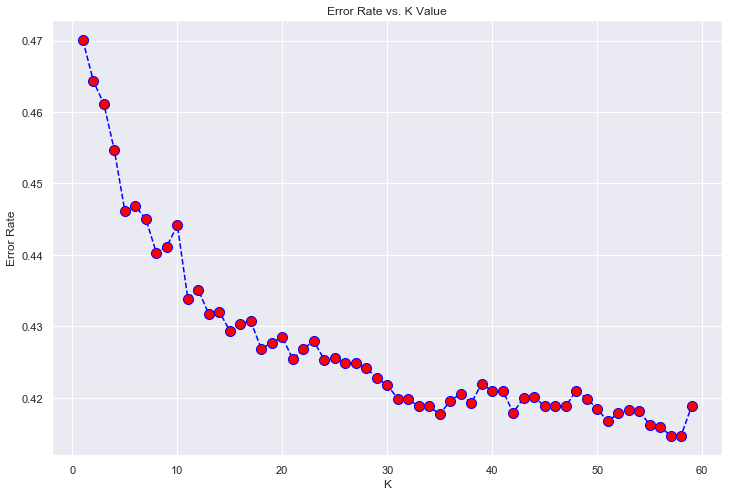

In [18]:
error_rate = []
for i in range(1, 60):
  knn = KNeighborsClassifier(n_neighbors=i)
  knn.fit(X_train,y_train)
  pred_i = knn.predict(X_test)
  error_rate.append(np.mean(pred_i != y_test))

plt.figure(figsize=(12, 8))
plt.plot(range(1, 60),error_rate,color='blue', linestyle='dashed',  marker='o',markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
print("Minimum error:-",min(error_rate),"at K =",error_rate.index(min(error_rate)))

Maximum accuracy:- 0.5852905502260448 at K = 56


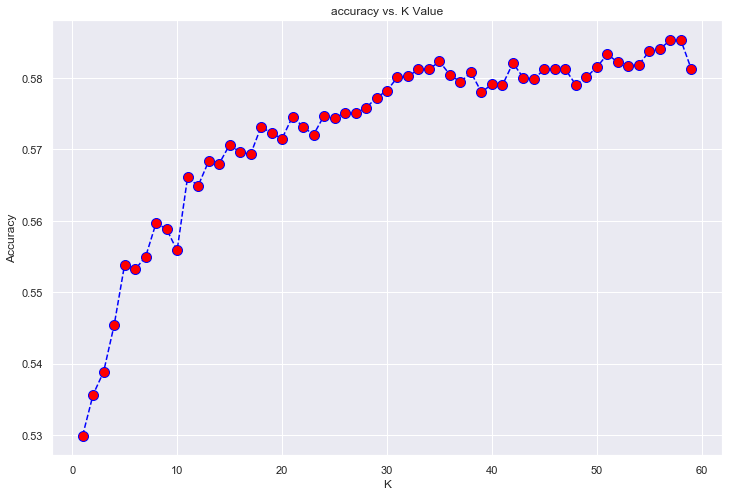

In [19]:
acc = []
# Will take some time
from sklearn import metrics
for i in range(1, 60):
  neigh = KNeighborsClassifier(n_neighbors = i).fit(X_train,y_train)
  yhat = neigh.predict(X_test)
  acc.append(metrics.accuracy_score(y_test, yhat))
    
plt.figure(figsize=(12, 8))
plt.plot(range(1, 60),acc,color = 'blue',linestyle='dashed', marker='o',markerfacecolor='red', markersize=10)
plt.title('accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')
print("Maximum accuracy:-",max(acc),"at K =",acc.index(max(acc)))

## KNN을 통한 피쳐 엔지니어링
- KNN as a Feature Engine

- KNN은 성능 면에서 다른 알고리즘에 비해 그리 좋은 편은 아님
- 하지만 실용적인 측면에서 다른 분류 방법들의 특정 단계에 사용할 수 있게 '지역적 정보(local knowledge)'를 추가하기 위해 사용할 수 있음
  - KNN으로 분류 확률(클래스에 속할 확률)을 얻는다.
  - 이 결과를 <span style="color:orange">새로운 예측변수로 다른 분류기에서 사용</span>한다. (원래의 변수를 두 번 사용하는 셈)
  - 그런데 다중공선성의 문제가 있진 않을까?

count    45342.000000
mean         0.501104
std          0.128734
min          0.000000
25%          0.400000
50%          0.500000
75%          0.600000
max          0.950000
Name: borrower_score, dtype: float64


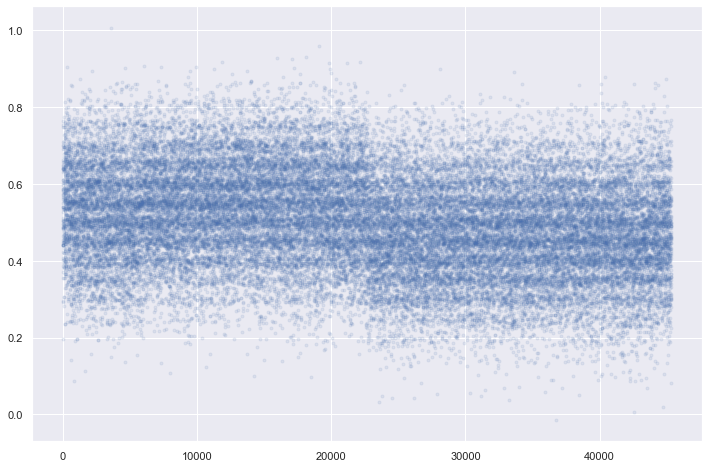

In [20]:
loan_data = pd.read_csv('./data/loan_data.csv.gz', compression='gzip')
loan_data = loan_data.drop(columns=['Unnamed: 0', 'status'])
loan_data['outcome'] = pd.Categorical(loan_data['outcome'], 
                                      categories=['paid off', 'default'], 
                                      ordered=True)

predictors = ['dti', 'revol_bal', 'revol_util', 'open_acc', 'delinq_2yrs_zero', 'pub_rec_zero']
outcome = 'outcome'

X = loan_data[predictors]
y = loan_data[outcome]

knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X, y)
plt.figure(figsize=(12, 8))
plt.scatter(range(len(X)), [bs + random.gauss(0, 0.015) for bs in knn.predict_proba(X)[:,0]], alpha=0.1, marker='.')
knn.predict_proba(X)[:, 0]

loan_data['borrower_score'] = knn.predict_proba(X)[:, 0]
print(loan_data['borrower_score'].describe())

# 트리 모델

- 트리 모델은 아래와 같이 불림
  - 회귀 및 분석 트리(CART; Classification And Regression Tree) ⇢ <span style="color:orange">회귀</span>라는 말이 붙은 이유는 무엇인가?
  - 의사 결정 트리(Decision Tree)
  - 트리(Tree)
- 데이터 과학에서 가장 널리 사용되는 랜덤 포레스트(Random Forest)와 부스팅 모델링의 기초임
- 해석이 용이함

## 간단한 예제

In [21]:
import pydotplus
# import pydotplus 오류 발생 시 아래 링크 참고
# https://datascience.stackexchange.com/questions/37428/graphviz-not-working-when-imported-inside-pydotplus-graphvizs-executables-not

In [9]:
np.sort(loan3000.borrower_score.unique())

array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 ,
       0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 ])

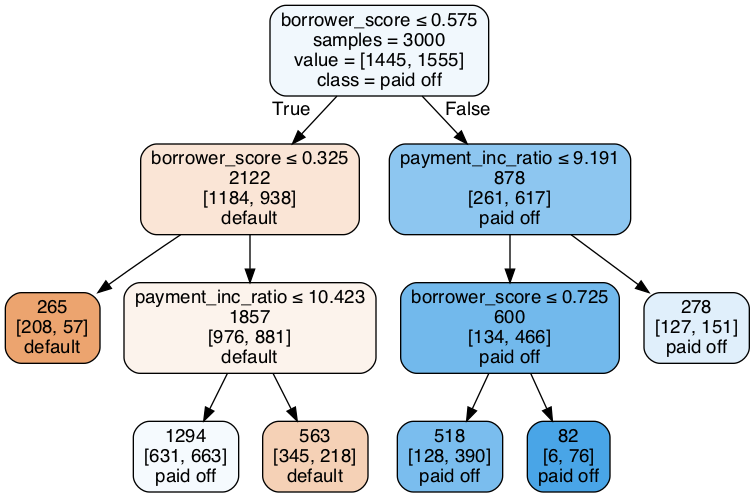

In [22]:
loan3000 = pd.read_csv('./data/loan3000.csv', index_col=0)

predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

X = loan3000[predictors]
y = loan3000[outcome]

loan_tree = DecisionTreeClassifier(random_state=1, criterion='entropy', min_impurity_decrease=0.003)
loan_tree.fit(X, y)
plotDecisionTree(loan_tree, feature_names=predictors, class_names=loan_tree.classes_)

In [23]:
print(textDecisionTree(loan_tree))

node=0 test node: go to node 1 if 0 <= 0.5750000178813934 else to node 6
  node=1 test node: go to node 2 if 0 <= 0.32500000298023224 else to node 3
    node=2 leaf node: [[0.785, 0.215]]
    node=3 test node: go to node 4 if 1 <= 10.42264986038208 else to node 5
      node=4 leaf node: [[0.488, 0.512]]
      node=5 leaf node: [[0.613, 0.387]]
  node=6 test node: go to node 7 if 1 <= 9.19082498550415 else to node 10
    node=7 test node: go to node 8 if 0 <= 0.7249999940395355 else to node 9
      node=8 leaf node: [[0.247, 0.753]]
      node=9 leaf node: [[0.073, 0.927]]
    node=10 leaf node: [[0.457, 0.543]]


## 재귀 분할 알고리즘
- The Recursive Partitioning Algorithm

- 의사 결정 트리를 만들 때는 재귀 분할이라고 하는 알고리즘을 사용함
- 예측변수 값을 기준으로 데이터를 반복적으로 분할해 나가는 방법임
  - 단, 분할할 때에는 상대적으로 같은 클래스의 데이터들끼리 구분되도록 하는 것이 핵심임

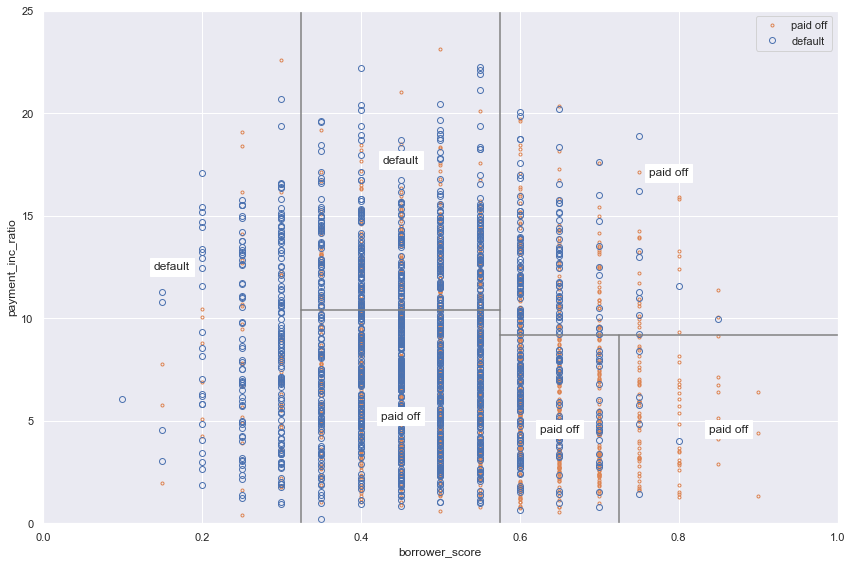

In [24]:
fig, ax = plt.subplots(figsize=(12, 8))

loan3000.loc[loan3000.outcome=='paid off'].plot(
    x='borrower_score', y='payment_inc_ratio', style='.', 
    markerfacecolor='none', markeredgecolor='C1', ax=ax)
loan3000.loc[loan3000.outcome=='default'].plot(
    x='borrower_score', y='payment_inc_ratio', style='o', 
    markerfacecolor='none', markeredgecolor='C0', ax=ax)
ax.legend(['paid off', 'default']);
ax.set_xlim(0, 1)
ax.set_ylim(0, 25)
ax.set_xlabel('borrower_score')
ax.set_ylabel('payment_inc_ratio')

x0 = 0.575
x1a = 0.325; y1b = 9.191
y2a = 10.423; x2b = 0.725
ax.plot((x0, x0), (0, 25), color='grey')
ax.plot((x1a, x1a), (0, 25), color='grey')
ax.plot((x0, 1), (y1b, y1b), color='grey')
ax.plot((x1a, x0), (y2a, y2a), color='grey')
ax.plot((x2b, x2b), (0, y1b), color='grey')

labels = [('default', (x1a / 2, 25 / 2)),
          ('default', ((x0 + x1a) / 2, (25 + y2a) / 2)),
          ('paid off', ((x0 + x1a) / 2, y2a / 2)),
          ('paid off', ((1 + x0) / 2, (y1b + 25) / 2)),
          ('paid off', ((1 + x2b) / 2, (y1b + 0) / 2)),
          ('paid off', ((x0 + x2b) / 2, (y1b + 0) / 2)),
         ]
for label, (x, y) in labels:
    ax.text(x, y, label, bbox={'facecolor':'white'},
            verticalalignment='center', horizontalalignment='center')

plt.tight_layout()
plt.show()

In [25]:
def entropyFunction(x):
    if x == 0:
      return 0
    elif x == 1:
      return x * math.log(x, 2)
    else:
      return -x * math.log(x, 2) - (1 - x) * math.log(1 - x, 2)

entropy = {}

for i in np.sort(loan3000['borrower_score'].unique()):
  
  a = loan3000[loan3000['borrower_score']<=i].shape[0]   
  b = loan3000[(loan3000['borrower_score']<=i)&(loan3000['outcome']=='paid off')].shape[0]
  
  c = loan3000[loan3000['borrower_score']>i].shape[0]
  d = loan3000[(loan3000['borrower_score']>i)&(loan3000['outcome']=='paid off')].shape[0]
  
  e = loan3000.shape[0]
  
  r1 = a/e
  r0 = c/e
  try:
    p1 = b/a
  except:
    p1 = 0
  try:
    p0 = d/c
  except:
    p0 = 0
    
  x = (r1 * entropyFunction(p1)) + (r0 * entropyFunction(p0))
  entropy[i] = x

In [26]:
print('borrower_score가 0.55에서 에서 엔트로피 값이 최소임을 알 수 있음')
entropy

borrower_score가 0.55에서 에서 엔트로피 값이 최소임을 알 수 있음


{0.1: 0.9986785869571139,
 0.15: 0.9988701687393516,
 0.2: 0.9959644752531347,
 0.25: 0.9899813428970902,
 0.3: 0.972016535797087,
 0.35: 0.9672009682085102,
 0.4: 0.9642450461657988,
 0.45: 0.9639336398315361,
 0.5: 0.9618897888546287,
 0.55: 0.9573997012563817,
 0.6: 0.9651934984718862,
 0.65: 0.9711597456185234,
 0.7: 0.9841706450797238,
 0.75: 0.9904657514283969,
 0.8: 0.9965729446285977,
 0.85: 0.9980812520116805,
 0.9: 0.999029970907025}

## 동질성과 불순도 측정하기
- Measuring Homogeneity or Impurity

- 파티션 내 오분류된 레코드의 비율 $p$로 예측의 정확도를 표시하고, 이는 0(완전)에서 0.5(순수 랜덤 추측)의 값을 갖음
- 그런데 정확도는 불순도를 측정하는 데 그닥 좋지 못하므로 지니 불순도(Gini impurity)와 엔트로피(Entropy)가 대표적인 불순도 측정 지표임
- 불순도 지표들은 클래스가 2개 이상인 분류 문제에도 적용 가능
- <span style="color:orange">영역의 순도(homogeneity)가 증가</span> or <span style="color:orange">불확실성(엔트로피)가 최대한 감소</span>하도록 하는 방향으로 학습을 진행함
---
- Gini impurity: $ {\displaystyle p(1-p)} $
  - <span style="color:orange"> $ {\displaystyle \sum_{i=1}^d (R_i (-\sum_{k=1}^m p_{ik}^2)) }$ </span>
- Entropy: $ {\displaystyle -p{log_2(p)-(1-p)log_2(1-p)} } $ = <span style="color:orange">$ {\displaystyle -\sum_{k=1}^m p_k*log_2(p_k) }$ </span>
  - <span style="color:orange"> $ {\displaystyle \sum_{i=1}^d R_i (-\sum_{k=1}^m p_k*log_2(p_k)) }$ </span>
  - 모든 레코드가 동일한 클래스일 경우 엔트로피 값은?
  - 클래스가 반반일 경우 엔트로피 값은?
- $R_i$ = 분할 전 레코드 가운데 분할 후 i 영역에 속하는 레코드의 비율
- $P_k$ = k 범주에 속하는 레코드의 비율
---
[참고](https://ratsgo.github.io/machine%20learning/2017/03/26/tree/)

In [27]:
def entropyFunction(x):
    if x == 0: return 0
    return -x * math.log(x, 2) - (1 - x) * math.log(1 - x, 2)

def giniFunction(x):
    return x * (1 - x)

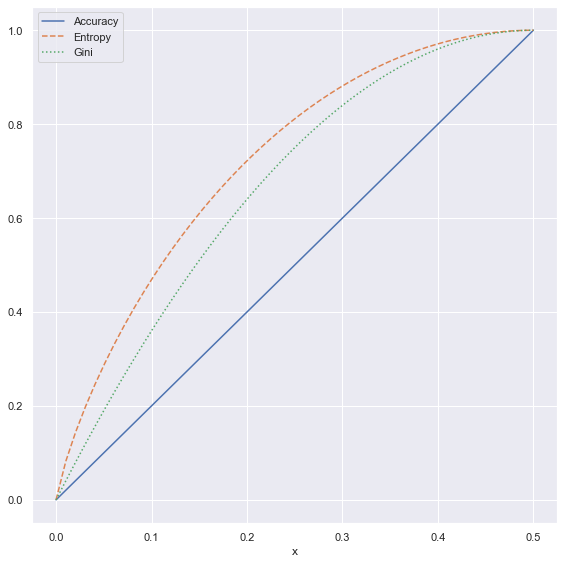

In [28]:
x = np.linspace(0, 0.5, 50)
impure = pd.DataFrame({
    'x': x,
    'Accuracy': 2 * x,
    'Gini': [giniFunction(xi) / giniFunction(.5) for xi in x],
    'Entropy': [entropyFunction(xi) for xi in x],
})

fig, ax = plt.subplots(figsize=(8, 8))

impure.plot(x='x', y='Accuracy', ax=ax, linestyle='solid')
impure.plot(x='x', y='Entropy', ax=ax, linestyle='--')
impure.plot(x='x', y='Gini', ax=ax, linestyle=':')

plt.tight_layout()
plt.show()

## 트리 형성 중지하기
- pruning

- 완전히 자란 트리는 오버피팅이 되기 때문에 <span style="color:orange">가지치기</span>가 필요함
- 가지치기는 데이터를 버리는 개념이 아니고 분기를 합치는(merge) 개념임
- CP(Complexity Parameter)를 이용해 트리를 죄적화함 (일종의 Hyperparameter)
- <span style="color:orange">$ CC(T)=Err(T)+α*L(T) $</span> (이것을 최소화하는 트리를 탐색해야 함)
  - $CC(T)$ = 의사결정나무의 비용 복잡도(=오류가 적으면서 terminal node 수가 적은 단순한 모델일 수록 작은 값)
  - $ERR(T)$ = 검증데이터에 대한 오분류율
  - $L(T)$ = terminal node의 수(구조의 복잡도)
  - $Alpha; CP$ = $ERR(T)$와 $L(T)$를 결합하는 가중치(사용자에 의해 부여됨, 보통 0.01~0.1의 값을 씀)
    
- Pruning 과정
  - 1) 데이터를 train과 test(validation)으로 나눈다
  - 2) trian으로 트리를 키운다
  - 3) 매 단계마다 cp를 기록한다
  - 4) validation에서 최소 에러(손실)을 보이는 cp를 기록한다
  - 5) 1~4를 다시 반복한다
  - 6) 각 트리에서 최소 에러를 보이는 cp 값의 평균을 구한다
  - 7) 원래 데이터를 이용해 위에서 구한 cp의 최적값을 가지고 트리를 만든다

## 연속값 예측하기

- <span style="color:orange">하위 분할 영역(Node)에서 평균으로부터의 편차들을 제곱한 값을 이용</span>하여 불순도를 측정함
- RMSE로 예측 성능을 평가함

## 트리 활용하기(결론)

- 시각화가 가능하여 <span style="color:orange">변수 간 관계</span>를 한 눈에 볼 수 있음 ⇢ 비 전문가들과 대화하는 데 효과적임
- 계산복잡성 대비 높은 예측 성능을 내는 것으로 알려져 있음
- 다만 의사결정나무는 결정경계(decision boundary)가 데이터 축에 <span style="color:orange">수직</span>이어서 특정 데이터에만 잘 작동할 가능성이 높음
  - 이같은 문제를 극복하기 위해 등장한 모델이 바로 <span style="color:orange">랜덤포레스트</span>임
  - 같은 데이터에 대해 의사결정나무를 여러 개 만들어 그 결과를 종합해 예측 성능을 높이는 기법

# 배깅과 랜덤 포레스트
- Bagging and the Random Forest

- <span style="color:orange">앙상블</span> 방법
  - 주어진 데이터에 대해 예측 모델을 만들고 예측 결과를 기록한다
  - 같은 데이터에 대해 <span style="color:orange">여러</span> 모델을 만들고 결과를 기록한다
  - 각 레코드에 대해 예측된 결과들의 평균(또는 가중평균, 다수결 투표)을 구한다


## 배깅
- <span style="color:orange">Bagging</span>; Bootstrap aggregation

- 1) 만들 모델의 개수 M과 모델을 만드는 데 사용할 레코드의 개수 $n(n<N)$의 값을 초기화한다 (반복 변수 $m=1$)
- 2) 훈련 데이터로부터 복원추출 방법으로 $n$개의 부분 데이터 $Y_m$과 $X_m$을 부트스트랩 재표본 추출
- 3) 의사 결정 규칙 $\hat{f}_m(X)$를 얻기 위해 $Y_m$과 $X_m$을 이용해 모델을 학습
- 4) $m=m+1$로 모델 개수를 늘리고 $m<M$이면 다시 1단계로 돌아간다
- $\hat{f}_m$이 $Y=1$인 경우의 확률을 예측한다고 했을 때 배깅 추정치는 다음과 같음
  - $\displaystyle {\hat{f}}$ = $\displaystyle \frac{1}{M}(\hat{f_1}(X) + \hat{f_2}(X) + ... + \hat{f_M}(X)) $

## 랜덤 포레스트
- Random Forest

- Decision Tree에 배깅을 적용한 모델임 ⇢ 레코드를 표본추출할 때 <span style="color:orange">변수도 샘플링</span>을 함
  - 1) 전체 데이터로부터 부트스트랩(복원추출)
  - 2) 첫 분할을 위해 비복원 랜덤추출로 $p(p<P)$개의 변수 샘플링
  - 3) 샘플링된 변수 $X_{j(1)}, X_{j(2)}, ...,  X_{j(p)}$에 대한 <span style="color:orange">분할 알고리즘</span> 적용
    - a) $X_{j(k)}$의 각 변수 $s_{j(k)}$에 대해
      - 파티션 A에 있는 레코드들을 $X_{j(k)}$ < $s_{j(k)}$인 하위 영역과 $X_{j(k)}$ >= $s_{j(k)}$인 하위 영역으로 나눈다
      - A의 각 하위 영역 내부의 클래스의 동질성(엔트로피, 지니 불순도)을 측정
    - b) 분할 영역 내부의 클래스 동질성을 최대로 하는 $s_{j(k)}$의 값을 선택한다
  - 4) 분할 영역 내부의 클래스 동질성을 최대로하는 $X_{j(k)}$ 와 $s_{j(k)}$값을 선택한다
  - 5) 다음 분할을 진행하기 위해 2단계부터 이전 단계들을 반복
  - 6) 트리가 모두 자랄 때까지 위와 같은 분할 과정 반복
  - 7) 1단계로 돌아가 또 다른 부트스트랩 표본을 추출해 같은 과정 반복
  
- 단계마다 선택하는 샘플 변수 개수? 일반적으로 <span style="color:orange">$\sqrt P$</span>개
- <span style="color:orange">OOB</span>(Out Of Bag) 추정 에러: 트리 모델을 만들 때 사용했던 학습 데이터에 속하지 않는 데이터를 사용하여 학습된 모델의 오차율
---
- 랜덤 포레스트는 일종의 블랙박스 모델임
- 단순한 단일 트리 모델보다는 훨씬 강력한 성능을 보이지만 간단한 트리는 통해 얻을 수 있는 직관적인 해석은 불가능
- 오버피팅이 되는 경우가 종종 존재

In [5]:
df = loan3000.reset_index(drop=True)
tmp = pd.get_dummies(df['purpose_'], drop_first=False)
df.drop(columns='purpose_', inplace=True)
df = pd.concat([df, tmp], axis=1)
df.head()

,outcome,dti,borrower_score,payment_inc_ratio,credit_card,debt_consolidation,home_improvement,major_purchase,medical,other,small_business
0,paid off,21.23,0.40,5.11135,0,1,0,0,0,0,0
1,default,15.49,0.40,5.43165,1,0,0,0,0,0,0
2,paid off,27.30,0.70,9.23003,0,1,0,0,0,0,0
3,paid off,21.11,0.40,2.33482,0,0,0,1,0,0,0
4,default,16.46,0.45,12.10320,0,1,0,0,0,0,0


In [54]:
var_num = int(np.sqrt(df.shape[1]-1)) # 선택할 변수 개수
var_loc = np.arange(1, df.shape[1])

def entropyFunction(x):
    if x == 0:
      return 0
    elif x == 1:
      return x * math.log(x, 2)
    else:
      return -x * math.log(x, 2) - (1 - x) * math.log(1 - x, 2)

    
for _ in range(3):
  dataset = df.sample(n=df.shape[0], replace=True)
  var_list = np.random.choice(var_loc, size=var_num, replace=False)
  
  for col in var_list:
    dataset_sample = dataset.iloc[:, [0, col]]
    col_name = dataset_sample.columns[1]
    x = dataset_sample[col_name].unique()
    
    entropy = {}
    for v in x:
      x1 = dataset_sample[dataset_sample[col_name] < v].shape[0]
      x2 = dataset_sample[dataset_sample[col_name] >= v].shape[0]
      
      y1 = dataset_sample[(dataset_sample[col_name] < v) & (dataset_sample['outcome']=='paid off')].shape[0]
      y2 = dataset_sample[(dataset_sample[col_name] >= v) & (dataset_sample['outcome']=='paid off')].shape[0]
      
      total = dataset_sample.shape[0]
      
      r1 = x1/total
      r0 = x2/total
      
      try:
        p1 = y1/x1
      except:
        p1 = 0
      try:
        p0 = y2/x2
      except:
        p0 = 0
      
      e = (r1 * entropyFunction(p1)) + (r0 * entropyFunction(p0))
      entropy[v] = e

In [29]:
predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

X = loan3000[predictors]
y = loan3000[outcome]

rf = RandomForestClassifier(n_estimators=500, random_state=1, oob_score=True, n_jobs=-1)
rf.fit(X, y)
print(rf.oob_decision_function_)

[[0.18131868 0.81868132]
 [0.26704545 0.73295455]
 [0.93333333 0.06666667]
 ...
 [1.         0.        ]
 [0.73157895 0.26842105]
 [0.68085106 0.31914894]]


In [31]:
n_estimator = list(range(20, 510, 5))
oobScores = []
for n in n_estimator:
    rf = RandomForestClassifier(n_estimators=n, 
                                criterion='entropy',
                                max_depth=5,
                                random_state=1,
                                oob_score=True)
    rf.fit(X, y)
    oobScores.append(rf.oob_score_)

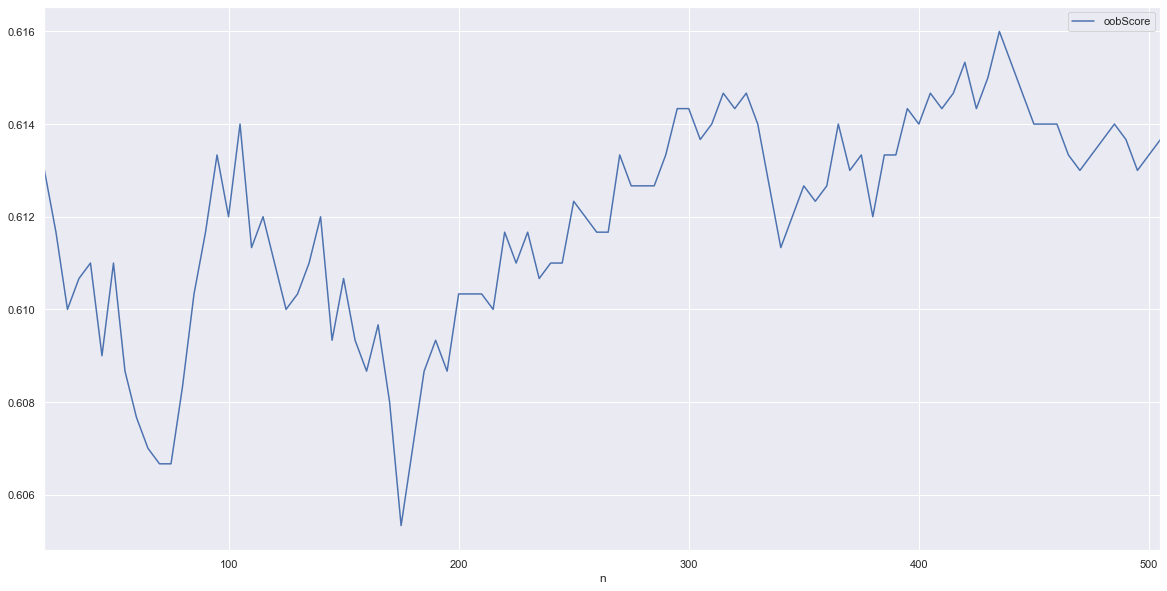

In [121]:
pd.DataFrame({
    'n': n_estimator, 
    'oobScore': oobScores
}).plot(x='n', y='oobScore')

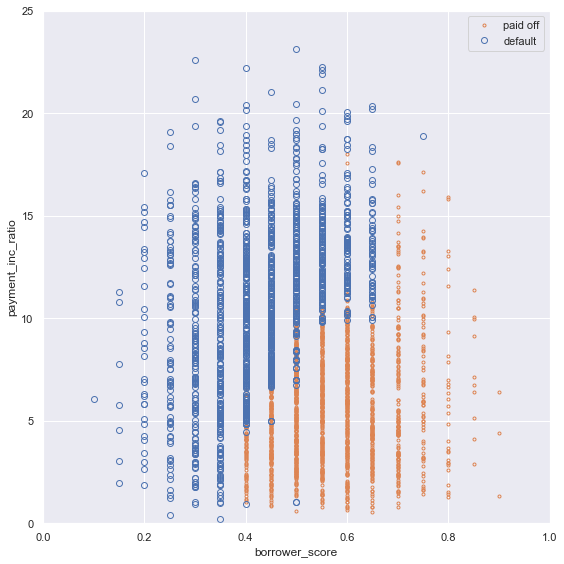

In [123]:
predictions = X.copy()
predictions['prediction'] = rf.predict(X)
predictions.head()

fig, ax = plt.subplots(figsize=(8, 8))

predictions.loc[predictions.prediction=='paid off'].plot(
    x='borrower_score', y='payment_inc_ratio', style='.',
    markerfacecolor='none', markeredgecolor='C1', ax=ax)
predictions.loc[predictions.prediction=='default'].plot(
    x='borrower_score', y='payment_inc_ratio', style='o',
    markerfacecolor='none', markeredgecolor='C0', ax=ax)
ax.legend(['paid off', 'default']);
ax.set_xlim(0, 1)
ax.set_ylim(0, 25)
ax.set_xlabel('borrower_score')
ax.set_ylabel('payment_inc_ratio')

plt.tight_layout()
plt.show()

## 변수 중요도
- Variable importance
- Feature importance

- RF는 변수와 행이 많을 수록 강력해진다
- 어떤 변수가 중요한지, 각 변수간 상관관계를 찾아내기 때문

In [124]:
predictors = ['loan_amnt', 'term', 'annual_inc', 'dti', 
              'payment_inc_ratio', 'revol_bal', 'revol_util', 
              'purpose', 'delinq_2yrs_zero', 'pub_rec_zero', 
              'open_acc', 'grade', 'emp_length', 'purpose_', 
              'home_', 'emp_len_', 'borrower_score']
outcome = 'outcome'

X = pd.get_dummies(loan_data[predictors], drop_first=True)
y = loan_data[outcome]

rf_all = RandomForestClassifier(n_estimators=500, random_state=1)
rf_all.fit(X, y)

rf_all_entropy = RandomForestClassifier(n_estimators=500, random_state=1, criterion='entropy')
print(rf_all_entropy.fit(X, y))

RandomForestClassifier(criterion='entropy', n_estimators=500, random_state=1)


In [125]:
rf = RandomForestClassifier(n_estimators=500)
scores = defaultdict(list)
 
# crossvalidate the scores on a number of different random splits of the data
for _ in range(3):
    train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.3)
    rf.fit(train_X, train_y)
    acc = metrics.accuracy_score(valid_y, rf.predict(valid_X))
    for column in X.columns:
        X_t = valid_X.copy()
        X_t[column] = np.random.permutation(X_t[column].values)
        shuff_acc = metrics.accuracy_score(valid_y, rf.predict(X_t))
        scores[column].append((acc-shuff_acc)/acc)
print('Features sorted by their score:')
print(sorted([(round(np.mean(score), 4), feat) for feat, score in scores.items()], reverse=True))

Features sorted by their score:
[(0.0741, 'borrower_score'), (0.0383, 'grade'), (0.0276, 'term_60 months'), (0.0129, 'annual_inc'), (0.0073, 'payment_inc_ratio'), (0.0051, 'revol_bal'), (0.0024, 'purpose_small_business'), (0.0021, 'dti'), (0.0019, 'purpose__small_business'), (0.0012, 'open_acc'), (0.0008, 'purpose_credit_card'), (0.0006, 'pub_rec_zero'), (0.0005, 'purpose_major_purchase'), (0.0003, 'purpose_vacation'), (0.0003, 'delinq_2yrs_zero'), (0.0001, 'purpose__debt_consolidation'), (0.0001, 'home__OWN'), (0.0, 'emp_len__ > 1 Year'), (-0.0001, 'purpose_moving'), (-0.0001, 'purpose_house'), (-0.0002, 'purpose_wedding'), (-0.0002, 'purpose_medical'), (-0.0002, 'purpose_home_improvement'), (-0.0003, 'purpose__medical'), (-0.0003, 'emp_length'), (-0.0005, 'purpose_other'), (-0.0006, 'purpose__major_purchase'), (-0.0006, 'purpose__home_improvement'), (-0.001, 'purpose__other'), (-0.001, 'loan_amnt'), (-0.0011, 'home__RENT'), (-0.0018, 'purpose_debt_consolidation'), (-0.0022, 'revol_ut

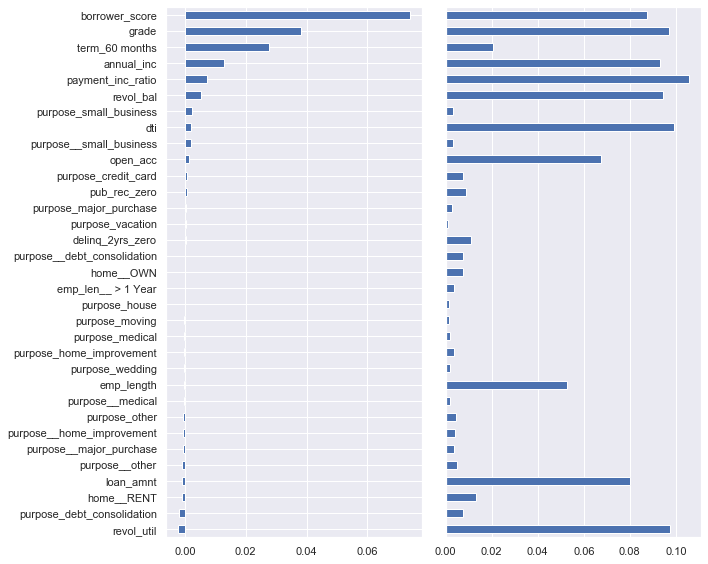

In [126]:
importances = rf_all.feature_importances_

df = pd.DataFrame({
    'feature': X.columns, 
    'Accuracy decrease': [np.mean(scores[column]) for column in X.columns],
    'Gini decrease': rf_all.feature_importances_, 
    'Entropy decrease': rf_all_entropy.feature_importances_,
})
df = df.sort_values('Accuracy decrease')

fig, axes = plt.subplots(ncols=2, figsize=(10, 8))
ax = df.plot(kind='barh', x='feature', y='Accuracy decrease', legend=False, ax=axes[0])
ax.set_ylabel('')

ax = df.plot(kind='barh', x='feature', y='Gini decrease', legend=False, ax=axes[1])
ax.set_ylabel('')
ax.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()

- 정확도 감소량이 좀 더 믿을만한 지표라면 지니 불순도를 굳이 고려할 필요가 있는가?
- 기본적으로 RF는 지니 불순도만을 활용함
- 모델의 정확도는 추가적인 계산이 필요한 반면, 지니 불순도는 알고리즘 상에서 부차적으로 얻어지는 결과물임
- 예를 들얼 몇 천개의 모델을 만들어야 해서 계산 복잡도가 중요하다면 계산을 더 해서 얻는 이득은 거의 없을 것임
- 또한, 지니 불순도의 감소를 통해 분할 규칙을 만드는 데 어떤 변수를 사용하는 것이 좋은지 분명히 알 수 있음

## 하이퍼파라미터
- Hyperparameter

- 학습 전에 미리 정해야 하는 파라미터임(학습 과정 중에 최적화되지 않음)
- 오버피팅을 피하기 위해 매우 중요한 파라미터임
- RF에서는 두 가지 Hyperparameter가 있음
  - nodesize: 노드 크기(데이터 수)
  - maxnodes: 결정 트리에서의 전체 노드 수

# 부스팅
- Boosting

- 부스팅: 모델들을 앙상블 형태로 만들기 위한 일반적인 기법
  - 배깅과 마찬가지로 결정 트리에 주로 가장 많이 사용 됨

- 오차를 줄이는 것이 핵심
  - 에이다부스트(AdaBoost)
  - 그레디언트 부스팅(Gradient Boosting)
  - 확률적 그레디언트 부스팅(Stochastic Gradient Boosting) ⇢ XGBoost
 

## 부스팅 알고리즘

- 

## XGboost

In [11]:
predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

X = loan3000[predictors]
y = loan3000[outcome]

xgb = XGBClassifier(objective='binary:logistic', subsample=.63)
print(xgb.fit(X, y))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.63,
              tree_method='exact', validate_parameters=1, verbosity=None)


In [12]:
xgb_df = X.copy()
xgb_df['prediction'] = xgb.predict(X)
xgb_df['prob_default'] = xgb.predict_proba(X)[:, 0]
print(xgb_df.head())

       borrower_score  payment_inc_ratio prediction  prob_default
32109            0.40            5.11135   paid off      0.171144
16982            0.40            5.43165    default      0.739844
25335            0.70            9.23003    default      0.679195
34580            0.40            2.33482   paid off      0.321995
14424            0.45           12.10320    default      0.859796


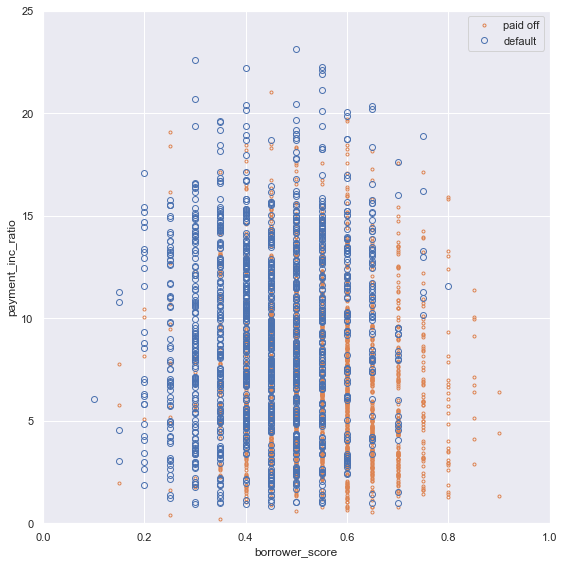

In [14]:
fig, ax = plt.subplots(figsize=(8, 8))

xgb_df.loc[xgb_df.prediction=='paid off'].plot(
    x='borrower_score', y='payment_inc_ratio', style='.', 
    markerfacecolor='none', markeredgecolor='C1', ax=ax)
xgb_df.loc[xgb_df.prediction=='default'].plot(
    x='borrower_score', y='payment_inc_ratio', style='o', 
    markerfacecolor='none', markeredgecolor='C0', ax=ax)
ax.legend(['paid off', 'default']);
ax.set_xlim(0, 1)
ax.set_ylim(0, 25)
ax.set_xlabel('borrower_score')
ax.set_ylabel('payment_inc_ratio')

plt.tight_layout()
plt.show()